(floris_models)=

# FLORIS Models

This notebook provides information on the provided FlorisModels. [Introductory Concepts](intro_concepts) introduced `FlorisModel` as the base class for all models in the FLORIS package. This notebook introduces the `ParFlorisModel`, `UncertainFlorisModel`, and `ApproxFlorisModel` classes, which are subclasses or compositions of `FlorisModel`.


## Parallelized FLORIS Model

The `ParFlorisModel` class is a subclass of `FlorisModel` that parallelizes the FLORIS calculations. This class is designed to 
have an interface that is the same as `FlorisModel`, but the calculations are parallelized. 

### Instantiation

The `ParFlorisModel` class can be instantiated in the same way as the `FlorisModel` class, or else it can be instantiated by passing a `FlorisModel` object to the constructor. 


In [1]:
from floris import FlorisModel, ParFlorisModel, TimeSeries
import numpy as np
import matplotlib.pyplot as plt

fmodel = FlorisModel("gch.yaml")

# Instantiation using yaml input file
pfmodel = ParFlorisModel("gch.yaml")

# Instantiation using fmodel
pfmodel = ParFlorisModel(fmodel)

### Parameters

The `ParFlorisModel` class has additional parameters the define the parallelization. These parameters are:

**interface**: The parallelization interface to use. Options are `"multiprocessing"`,
    `"pathos"`, and `"concurrent"`, with possible future support for `"mpi4py"`

**max_workers**: The maximum number of workers to use. Defaults to -1, which then
    takes the number of CPUs available.

**n_wind_condition_splits**: The number of wind conditions to split the simulation over.
    Defaults to the same as max_workers.

**return_turbine_powers_only**: Whether to return only the turbine powers.

**print_timings** (bool): Print the computation time to the console. Defaults to False.

In [2]:
# Alternative parameters
pfmodel = ParFlorisModel(fmodel, max_workers=2)

### Usage

The `ParFlorisModel` class can be used in the same way as the `FlorisModel` class. The only difference is that the calculations are parallelized. 

```python

In [3]:
# Set to a two turbine layout
layout_x = [0, 500]
layout_y = [0, 0]
fmodel.set(layout_x=layout_x, layout_y=layout_y)
pfmodel.set(layout_x=layout_x, layout_y=layout_y)

In [4]:
wind_directions = np.arange(240, 300, 0.5)
time_series = TimeSeries(
    wind_directions=wind_directions, wind_speeds=8.0, turbulence_intensities=0.06
)
fmodel.set(wind_data=time_series)
pfmodel.set(wind_data=time_series)

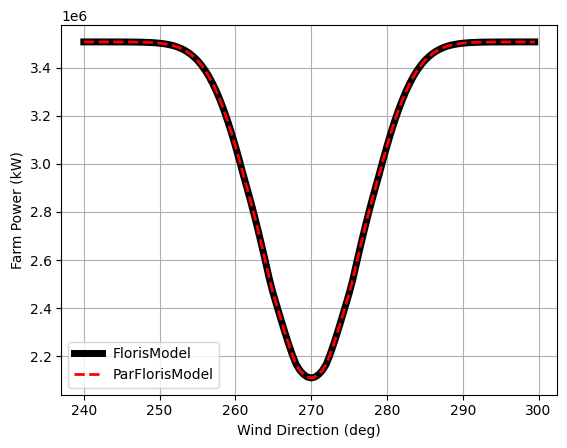

In [5]:
fmodel.run()
pfmodel.run()

farm_power = fmodel.get_farm_power()
pfarm_power = pfmodel.get_farm_power()

# Show the results are the same
fig, ax = plt.subplots()
ax.plot(wind_directions, farm_power, label="FlorisModel", color='k', lw=5)
ax.plot(wind_directions, pfarm_power, label="ParFlorisModel", color='r', ls='--', lw=2)
ax.set_xlabel("Wind Direction (deg)")
ax.set_ylabel("Farm Power (kW)")
ax.legend()
ax.grid()

## UncertainFlorisModel

The `UncertainFlorisModel` class is a composition of `FlorisModel` that adds uncertainty to the input conditions.  Its interface is meant to made similar to `FlorisModel`, but with the addition of uncertainty in wind direction.

### Instantiation

The `UncertainFlorisModel` class can be instantiated in the same way as the `FlorisModel` class, or else it can be instantiated by passing a `FlorisModel` object to the constructor.  Alternatively a `ParFlorisModel` object can be passed to the constructor which ensures the underlying calculations are parallelized according to the `ParFlorisModel` parameters.

In [6]:
from floris import UncertainFlorisModel

# Instantiation options
ufmodel = UncertainFlorisModel("gch.yaml") # Using input yaml
ufmodel = UncertainFlorisModel(fmodel) # Using a FlorisModel object
ufmodel = UncertainFlorisModel(pfmodel) # Using a ParFlorisModel object

### Parameters

To include uncertainty into the wind direction, the `UncertainFlorisModel` class, for each findex run, the result for a wind direction is provided by performing a Gaussian blend over results from multiple wind directions nearby wind directions.  To reduce the total number of calculations required, a resolution of wind direction, wind speed, turbulence intensity and control inputs are specified and repeated calculations are only calculated once.  See the class API for complete details but some key parameters are:

**wd_resolution, ws_resolution, ti_resolution, yaw_resolution, and power_setpoint_resolution**: Define the granularity of calculations for wind direction, wind speed, turbulence intensity, yaw angle, and power setpoints, respectively.

**wd_std**: The standard deviation of wind direction, used in the Gaussian blending.

**wd_sample_points**: Specific wind direction points to sample for expanded conditions.


In [7]:
# Define the uncertainty to have a wd_std of 5 degrees and blend over 10 degrees
ufmodel = UncertainFlorisModel(fmodel, wd_std=5, wd_sample_points=[-5, -4, -3, -2, -1, 0, 1, 2,3, 4, 5], wd_resolution=0.5)

### Usage

Usage of `UncertainFlorisModel` is similar to `FlorisModel` however the results will now include the effects of Gaussian blending


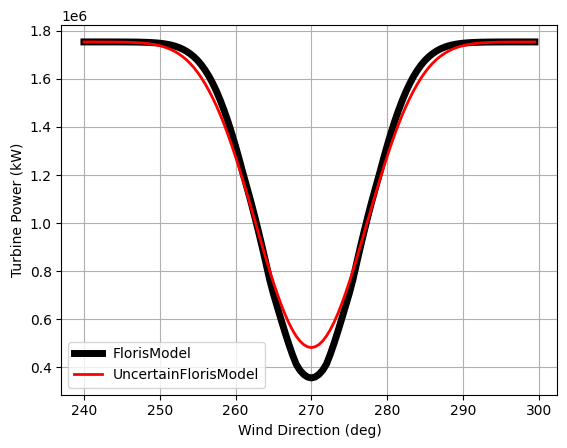

In [8]:
ufmodel.set(wind_data=time_series, layout_x=layout_x, layout_y=layout_y)
ufmodel.run()

# Get the power of the downstream turbine
f_power = fmodel.get_turbine_powers()[:,1]
uf_power = ufmodel.get_turbine_powers()[:,1]

# Plot the two powers
fig, ax = plt.subplots()
ax.plot(wind_directions, f_power, label="FlorisModel", color='k', lw=5)
ax.plot(wind_directions, uf_power, label="UncertainFlorisModel", color='r', lw=2)
ax.set_xlabel("Wind Direction (deg)")
ax.set_ylabel("Turbine Power (kW)")
ax.legend()
ax.grid()

## ApproxFlorisModel

   The ApproxFlorisModel overloads the UncertainFlorisModel with the special case that the `wd_sample_points = [0]`.  This is a special case where no uncertainty is added but the resolution of the values wind direction, wind speed etc are still reduced  by the specified resolution.  This allows for cases to be reused and a faster approximate result computed

### Instantiation

`ApproxFlorisModel` can be instantiated in the same way as the `UncertainFlorisModel` class

In [9]:
from floris import ApproxFlorisModel

# Instantiation options
amodel = ApproxFlorisModel("gch.yaml") # Using input yaml
amodel = ApproxFlorisModel(fmodel) # Using a FlorisModel object
amodel = ApproxFlorisModel(pfmodel) # Using a ParFlorisModel object

## Usage

`ApproxFlorisModel` is used in the same way as `UncertainFlorisModel` but with the special case that the `wd_sample_points = [0]`. This means that while the resolution of the values `wind_direction`, `wind_speeds` etc are still reduced by the specified resolution, no uncertainty is added. It is intended for quickly processing large sets of inflow conditions (e.g., when reproducing SCADA records), when approximate solutions are sufficient.



In [10]:
# Instantiate with a wind speed resolution of 0.5 m/s and a wind direction resolution of 1 degree
amodel = ApproxFlorisModel(fmodel, ws_resolution=0.5, wd_resolution=1.0) 

In [11]:
# Show approximation for a time series including smaller increments of wind speed
wind_speeds = np.arange(6, 10, 0.1)
time_series = TimeSeries(
    wind_directions = 270.0,
    wind_speeds=wind_speeds,
    turbulence_intensities=0.06
)
amodel.set(wind_data=time_series)

print(f"amodel has an n_findex of {amodel.n_findex}, ",
      f"however, the number of unique cases to run at this resolution is {amodel.n_unique}.")

amodel.run()
farm_power = amodel.get_farm_power()

amodel has an n_findex of 40,  however, the number of unique cases to run at this resolution is 9.


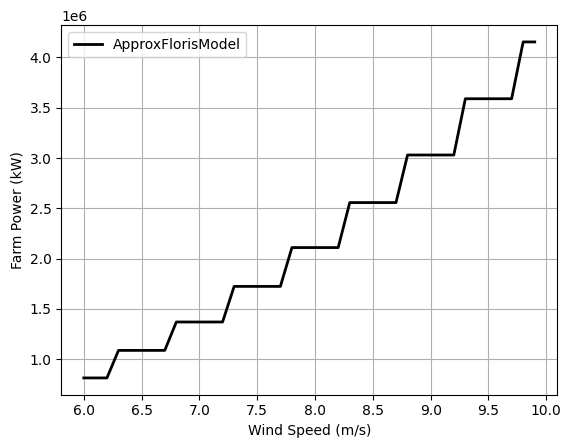

In [12]:
# Show the farm power over wind speeds
fig, ax = plt.subplots()
ax.plot(wind_speeds, farm_power, label="ApproxFlorisModel", color='k', lw=2)
ax.legend()
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Farm Power (kW)")
ax.grid()
